# **Image Classification using Convolutional Neural Network (CNN): CIFAR-10 dataset**

# Introduction

2D Convolutional Neural Networks or CNNs are a type of artificial neural network architecture that is extremely suited to the task of image classification because they effectively detect local and spatial patterns in data by applying appropriate filters.


CNNs for image classification consist of two main parts:

- Feature detection stage: During this stage, the CNN performs convolution, nonlinear activation (e.g., ReLU), and pooling (or subsampling) operations on the input image to detect spatial hierarchical patterns such as edges, textures, shapes, etc.

- Classification stage: After the feature detection stage, CNN uses fully connected layers to classify images based on the detected features. These layers are similar to those used in conventional neural networks.

# Code

## Importing libraries

In [ ]:
import wandb
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping

### Logging into wandb Weights & Biases

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: srishtilakhotia (srishtilakhotia-chennai-mathematical-institute) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Downloading, Extracting and Loading the Dataset

In [ ]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz #downloading the CIFAR-10 dataset from the source

--2025-02-26 13:18:31--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  45.3MB/s    in 4.0s    

2025-02-26 13:18:36 (40.5 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
!tar -xvzf cifar-10-python.tar.gz #extracting the dataset

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
# loading the dataset

import pickle
import numpy as np

# function to load a batch
def load_cifar10_batch(file):
    with open(file, 'rb') as f:
        batch = pickle.load(f, encoding='latin1')
    return batch['data'], batch['labels']

train_data = []
train_labels = []

for i in range(1, 6):
    file = f'cifar-10-batches-py/data_batch_{i}'
    data, labels = load_cifar10_batch(file)
    train_data.append(data)
    train_labels.append(labels)

print(type(train_data), len(train_data))
meta_file = 'cifar-10-batches-py/batches.meta'
with open(meta_file, 'rb') as f:
    class_labels = pickle.load(f, encoding='latin1')['label_names'] #extracting class labels from the meta file

train_data = np.concatenate(train_data)
train_labels = np.concatenate(train_labels)

test_data, test_labels = load_cifar10_batch('cifar-10-batches-py/test_batch')

train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) #shape = (50000, 32, 32, 3)
test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) # shape = (10000, 32, 32, 3)


In [ ]:
test_labels = np.array(test_labels) #test_labels is initially a list, so we convert to numpy arrays

In [ ]:
train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((50000, 32, 32, 3), (50000,), (10000, 32, 32, 3), (10000,))

In [ ]:
class_labels, len(class_labels)

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 10)

Thus, we have 60,000 coloured images in total, each 32 x 32 pixels, out of which 50,000 are in the training set and 10,000 in the test set.

We have ten image classes for our purposes.

## Pre-Processing of our images

In [ ]:
# Normalising the pixel values between 0 and 1

train_data = train_data / 255.0
test_data = test_data / 255.0

## EDA

### Visualising some images

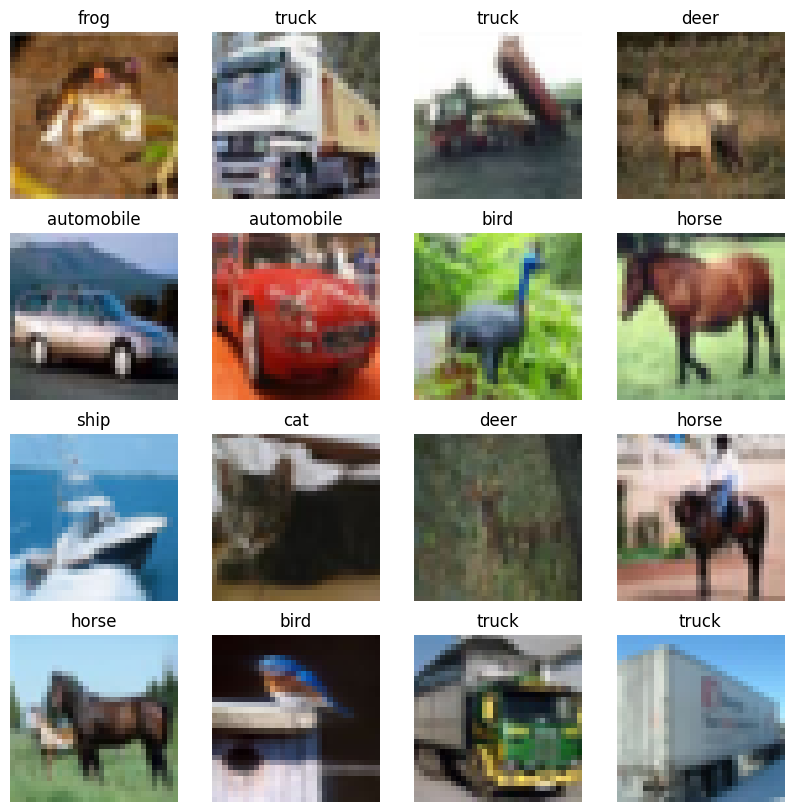

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(16):
    # plotting 16 images with labels
    plt.subplot(4, 4, i + 1)
    plt.imshow(train_data[i])
    plt.title(class_labels[train_labels[i]])
    plt.axis('off')
plt.show()

### Checking how the classes are balanced in the training set

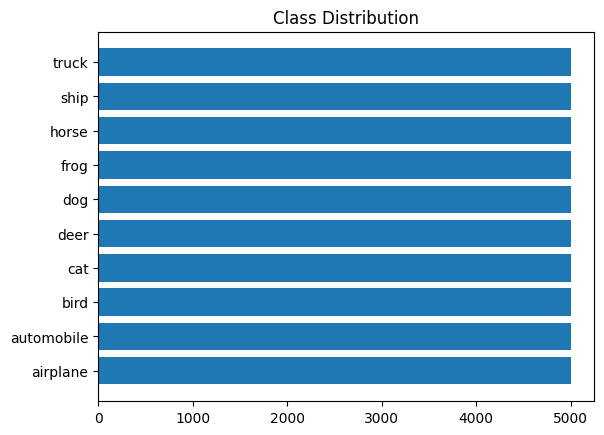

In [ ]:
unique, counts = np.unique(train_labels, return_counts=True) # getting a count of each label in the training set

# barplot
plt.barh(class_labels, counts )
plt.title("Class Distribution")
plt.show()

Thus, our data is balanced.

## Building and Training the CNN


We build a simple 4 layer model  with maxpooling (2 convolution layers, 2 fully connected dense layers). We use ReLU as our activation fucntion in the convolution layers and softmax as the activation function in the output layer. We also implement early stopping.

In [ ]:
def CNN(optimizer_type):
    model = models.Sequential()

    # layer 1
    model.add(Input((32,32,3)))
    model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
    model.add(layers.MaxPooling2D((2, 2))) #downsampling in each layer

    # layer 2
    model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # fully connected output layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dense(10, activation = 'softmax'))

    # model compiling
    model.compile(optimizer = optimizer_type,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

    # we use the sparse cross entropy since our labels are not one-hot encoded

    print(model.summary())

    return model


In [ ]:
def training(train_data, train_labels, model_configuration, optimizer_type, name):

    #initialising the run in W&B
    wandb.init(
        project="cifar10-cnn-classification",
        config=model_configuration,
        name=name
    )

    try:
        model = CNN(optimizer_type=optimizer_type)
        epochs = model_configuration["epochs"]

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,  # wait at least 5 epochs before stopping
            restore_best_weights=True
        )

        # training loop with W&B logging
        history = model.fit(
            train_data, train_labels,
            validation_data=(test_data, test_labels),
            batch_size=model_configuration['batch_size'],
            epochs=epochs,
            callbacks=[early_stopping]
        )

        # logging metrics for each epoch
        for i in range(len(history.history['loss'])):
            wandb.log({
                "epoch": i + 1,
                "train_loss": history.history['loss'][i],
                "val_loss": history.history['val_loss'][i],
                "train_accuracy": history.history['accuracy'][i],
                "val_accuracy": history.history['val_accuracy'][i]
            })

        # saving the model
        model.save("cifar10_model.keras")
        wandb.save("cifar10_model.keras")

    finally:
        # using try and finally to still be able to close the wandb initialisation even in cases where the code encounters an exception.
        wandb.finish()

## Experiment 1

In [ ]:
#setting hyperparameters for experiment 1

model_configuration = {
        "learning_rate": 0.001,
        "epochs": 20,
        "batch_size": 64,
        "optimizer": "adam"
        }

optimizer_type = keras.optimizers.Adam(learning_rate = model_configuration["learning_rate"])
training(train_data, train_labels, model_configuration, optimizer_type, name = "1st Experiment" )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,122,186 (8.10 MB)

 Trainable params: 2,122,186 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4187 - loss: 1.6006 - val_accuracy: 0.6112 - val_loss: 1.1179
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6520 - loss: 0.9968 - val_accuracy: 0.6760 - val_loss: 0.9243
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7167 - loss: 0.8076 - val_accuracy: 0.6966 - val_loss: 0.8840
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7638 - loss: 0.6707 - val_accuracy: 0.7041 - val_loss: 0.8802
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8135 - loss: 0.5339 - val_accuracy: 0.7186 - val_loss: 0.8402
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8615 - loss: 0.4021 - val_accuracy: 0.7266 - val_loss: 0.8814
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9017 - loss: 0.2905 - val_accuracy: 0.7253 - val_loss: 0.9430
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9353 - loss: 0.1987 - val_accurac

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▅▆▇██████
val_loss,▅▂▂▂▁▂▂▄▆█
epoch,10
train_accuracy,0.96656
train_loss,0.10442
val_accuracy,0.7249
val_loss,1.32823


training accuracy = 97.10%
validation accuracy = 72.49%

Thus, our basic CNN model runs with a 72.49% accuracy on unseen data. This is a good starting point for our model.

Next, we try running the model with a smaller learning rate and bigger batch size.

## Experiment 2

In [ ]:
# smaller learning rate, larger batch size

model_configuration = {
        "learning_rate": 0.0001,
        "epochs": 20,
        "batch_size": 128,
        "optimizer": "adam"
        }

optimizer_type = keras.optimizers.Adam(learning_rate = model_configuration["learning_rate"])
training(train_data, train_labels, model_configuration, optimizer_type, name = "2nd Experiment" )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,122,186 (8.10 MB)

 Trainable params: 2,122,186 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 113s 286ms/step - accuracy: 0.2938 - loss: 1.9725 - val_accuracy: 0.4618 - val_loss: 1.5278
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 137s 273ms/step - accuracy: 0.4802 - loss: 1.4788 - val_accuracy: 0.5211 - val_loss: 1.3620
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 139s 266ms/step - accuracy: 0.5336 - loss: 1.3407 - val_accuracy: 0.5474 - val_loss: 1.2876
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 149s 283ms/step - accuracy: 0.5656 - loss: 1.2431 - val_accuracy: 0.5686 - val_loss: 1.2290
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 135s 265ms/step - accuracy: 0.5803 - loss: 1.2002 - val_accuracy: 0.5909 - val_loss: 1.1738
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 104s 267ms/step - accuracy: 0.6030 - loss: 1.1384 - val_accuracy: 0.5994 - val_loss: 1.1379
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 145s 275ms/step - accuracy: 0.6206 - loss: 1.0988 - val_accuracy: 0.6064 - val_loss: 1.1129
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 145s 283ms/step - accuracy: 0.6

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


391/391 ━━━━━━━━━━━━━━━━━━━━ 147s 279ms/step - accuracy: 0.7378 - loss: 0.7670 - val_accuracy: 0.6853 - val_loss: 0.9029


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇█▇▇███
val_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▁▂▂▁▁▁
epoch,20
train_accuracy,0.736
train_loss,0.77143
val_accuracy,0.6853
val_loss,0.90291


training accuracy = 73.48%
validation accuracy = 69.01%

It seems that the model has not reached its full potential in 20 epochs. Both train accuracy and validation accuracy have reduced in this model. The smaller learning rate and bigger batch size seems to have slowed convergence. Thus we rerun our model with more epochs and a smaller batch size and a slightly bigger learning rate.

## Experiment 3

In [ ]:
model_configuration = {
        "learning_rate": 0.0005,
        "epochs": 30,
        "batch_size": 64,
        "optimizer": "adam"
        }

optimizer_type = keras.optimizers.Adam(learning_rate = model_configuration["learning_rate"])
training(train_data, train_labels, model_configuration, optimizer_type, name = "3rd Experiment" )

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,122,186 (8.10 MB)

 Trainable params: 2,122,186 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 114s 144ms/step - accuracy: 0.3949 - loss: 1.6818 - val_accuracy: 0.5725 - val_loss: 1.2034
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - accuracy: 0.6073 - loss: 1.1187 - val_accuracy: 0.6431 - val_loss: 1.0293
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - accuracy: 0.6661 - loss: 0.9496 - val_accuracy: 0.6624 - val_loss: 0.9551
Epoch 4/30
311/782 ━━━━━━━━━━━━━━━━━━━━ 1:01 130ms/step - accuracy: 0.7126 - loss: 0.8283

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


782/782 ━━━━━━━━━━━━━━━━━━━━ 138s 137ms/step - accuracy: 0.7096 - loss: 0.8338 - val_accuracy: 0.6827 - val_loss: 0.9119
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 137ms/step - accuracy: 0.7393 - loss: 0.7489 - val_accuracy: 0.7035 - val_loss: 0.8729
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 111s 142ms/step - accuracy: 0.7704 - loss: 0.6581 - val_accuracy: 0.7035 - val_loss: 0.8739
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 138s 136ms/step - accuracy: 0.8002 - loss: 0.5784 - val_accuracy: 0.7190 - val_loss: 0.8388
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 143s 138ms/step - accuracy: 0.8303 - loss: 0.4925 - val_accuracy: 0.7148 - val_loss: 0.8848
Epoch 9/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 109s 139ms/step - accuracy: 0.8590 - loss: 0.4208 - val_accuracy: 0.7303 - val_loss: 0.8377
Epoch 10/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 140s 137ms/step - accuracy: 0.8853 - loss: 0.3469 - val_accuracy: 0.7298 - val_loss: 0.8922
Epoch 11/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 107s 137ms/step - accuracy: 0.9100 - loss: 0.

training accuracy = 95.43% validation accuracy = 72.17%

This experiment seems to run very similar to Experiment 1. The learning rates 0.001 and 0.0005 seem to not make too much of a difference. Increasing the epochs also did not matter since Early Stopping was utilised in both these experiments.

Now, we vary our optimizer to compare how SGD performs against Adam.

## Experiment 4

In [ ]:
model_configuration = {
        "learning_rate": 0.001,
        "epochs": 20,
        "batch_size": 128,
        "optimizer": "sgd"
        }

optimizer_type = keras.optimizers.SGD(learning_rate = model_configuration["learning_rate"])
training(train_data, train_labels, model_configuration, optimizer_type, name = "4th Experiment" )

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,122,186 (8.10 MB)

 Trainable params: 2,122,186 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.0997 - loss: 2.3023 - val_accuracy: 0.1202 - val_loss: 2.2911
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1233 - loss: 2.2887 - val_accuracy: 0.1259 - val_loss: 2.2805
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1393 - loss: 2.2779 - val_accuracy: 0.1692 - val_loss: 2.2676
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1755 - loss: 2.2650 - val_accuracy: 0.1971 - val_loss: 2.2499
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2026 - loss: 2.2428 - val_accuracy: 0.2214 - val_loss: 2.2244
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2205 - loss: 2.2160 - val_accuracy: 0.2353 - val_loss: 2.1900
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2372 - loss: 2.1810 - val_accuracy: 0.2432 - val_loss: 2.1513
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2445 - loss: 2.1433 - val_accura

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇███
train_loss,███▇▇▇▆▆▅▅▄▄▃▃▂▂▂▂▁▁
val_accuracy,▁▁▂▃▄▄▄▅▅▆▆▆▇▇▇▇████
val_loss,███▇▇▇▆▅▅▄▄▃▃▃▂▂▂▁▁▁
epoch,20
train_accuracy,0.36586
train_loss,1.8222
val_accuracy,0.3681
val_loss,1.8099


training accuracy = 36.58%
validation accuracy = 36.81

The SGD Optimizer seems to be completely overshadowed by Adam for atleast the restriction of 20 epochs. However we do note that the model seems to have potential but the number of epochs are likely not sufficient.
The low training accuracy and painfully slow convergence could be aided to the fact that SGD is not adaptable. We try adding momentum to the SGD optimiser to help SGD accelerate in the right direction and dampens oscillations. Also, we increment the number of epochs to 50.

## Experiment 5

In [ ]:
model_configuration = {
        "learning_rate": 0.001,
        "epochs": 50,
        "batch_size": 128,
        "optimizer": "sgd"
        }
# increasing epochs

optimizer_type = keras.optimizers.SGD(learning_rate = model_configuration["learning_rate"], momentum=0.9) #adding momentum
training(train_data, train_labels, model_configuration, optimizer_type, name = "5th Experiment" )

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,122,186 (8.10 MB)

 Trainable params: 2,122,186 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1753 - loss: 2.2285 - val_accuracy: 0.3119 - val_loss: 1.9462
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3318 - loss: 1.9036 - val_accuracy: 0.3828 - val_loss: 1.7651
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3895 - loss: 1.7360 - val_accuracy: 0.4304 - val_loss: 1.6205
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4320 - loss: 1.6035 - val_accuracy: 0.4521 - val_loss: 1.5396
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4650 - loss: 1.5083 - val_accuracy: 0.4812 - val_loss: 1.4591
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4946 - loss: 1.4369 - val_accuracy: 0.4978 - val_loss: 1.4181
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5112 - loss: 1.3832 - val_accuracy: 0.5292 - val_loss: 1.3309
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5272 - loss: 1.3302 - val_accura

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▂▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
train_loss,█▇▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▂▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████
val_loss,█▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
epoch,48
train_accuracy,0.85578
train_loss,0.43279
val_accuracy,0.6849
val_loss,1.01639


This is a huge improvement over Experiment 4. However, both the training and validation accuracy still seem to be lower than what we had for the Adam optimizer.

## Increasing Convolutional Layers

To increase overall performance of the model, we fit another CNN model, this type with 2 more convolution layers.

In [ ]:
def CNN2(optimizer_type):
    model = models.Sequential()

    # layer 1
    model.add(Input((32,32,3)))
    model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
    model.add(layers.MaxPooling2D((2, 2))) #downsampling

    # layer 2
    model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # layer 3
    model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # layer 4
    model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
    model.add(layers.MaxPooling2D((2, 2)))


    # fully connected output layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dense(10, activation = 'softmax'))

    # model compiling

    model.compile(optimizer = optimizer_type,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

    # we use the sparse cross entropy since our labels are not one-hot encoded

    print(model.summary())

    return model


In [ ]:
def training_2(train_data, train_labels, model_configuration, optimizer_type, name):

    wandb.init(
        project="cifar10-cnn-classification",
        config=model_configuration,
        name=name
    )

    try:
        model = CNN2(optimizer_type=optimizer_type)
        epochs = model_configuration["epochs"]

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,  # wait at least 5 epochs before stopping
            restore_best_weights=True
        )

        # training loop with W&B logging
        history = model.fit(
            train_data, train_labels,
            validation_data=(test_data, test_labels),
            batch_size=model_configuration['batch_size'],
            epochs=epochs,
            callbacks=[early_stopping]
        )

        # logging metrics for each epoch
        for i in range(len(history.history['loss'])):
            wandb.log({
                "epoch": i + 1,
                "train_loss": history.history['loss'][i],
                "val_loss": history.history['val_loss'][i],
                "train_accuracy": history.history['accuracy'][i],
                "val_accuracy": history.history['val_accuracy'][i]
            })

        # saving the model
        model.save("cifar10_model.keras")
        wandb.save("cifar10_model.keras")

    finally:
        wandb.finish()

## Experiment 6

In [ ]:
model_configuration = {
        "learning_rate": 0.001,
        "epochs": 20,
        "batch_size": 64,
        "optimizer": "adam"
        }


optimizer_type = keras.optimizers.Adam(learning_rate = model_configuration["learning_rate"])
training_2(train_data, train_labels, model_configuration, optimizer_type, name = "6th Experiment" )

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 229,962 (898.29 KB)

 Trainable params: 229,962 (898.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.3313 - loss: 1.7915 - val_accuracy: 0.5794 - val_loss: 1.1750
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5842 - loss: 1.1396 - val_accuracy: 0.6369 - val_loss: 1.0039
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6694 - loss: 0.9338 - val_accuracy: 0.6629 - val_loss: 0.9526
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7108 - loss: 0.8132 - val_accuracy: 0.7097 - val_loss: 0.8183
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7452 - loss: 0.7161 - val_accuracy: 0.7107 - val_loss: 0.8188
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7719 - loss: 0.6401 - val_accuracy: 0.7276 - val_loss: 0.7803
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7973 - loss: 0.5731 - val_accuracy: 0.7294 - val_loss: 0.8037
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8141 - loss: 0.5271 - val_accura

epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train_accuracy,▁▄▅▅▆▆▇▇▇▇███
train_loss,█▅▄▄▃▃▃▂▂▂▁▁▁
val_accuracy,▁▃▅▇▇▇▇█▇████
val_loss,█▅▄▂▂▁▁▁▃▂▂▃▅
epoch,13
train_accuracy,0.88582
train_loss,0.3173
val_accuracy,0.7314
val_loss,0.97992


As expected, the deeper neural network outperforms the earlier model, but only by a very small margin (validation accuracy increases by ~1%). However, the training accuracy is not as high as Exepriment 1.

# Insights

- The initial CNN achieved 72% accuracy, which is pretty good for such a simple model.
- Hyperparameter tuning is very essential to good performance of the network.
- Increase in number of convulutional layers did not make a huge difference in the performance of the model.
- Many further improvements are possible in this model utilising concepts such as regularisation and data augmentention.

# Conclusion

CNNs are a powerful tool for image classification, even the simplest CNNs can achieve a high accuracy. However, there is a lot of room for improvement on the model in our case.
